In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Project Phases:
* Libraries and Data Loading
* Exploratory Analysis and Data Cleaning
* Machine Learning
* Christmas Adjustment

# 1. Libraries and Data Loading 

We will be loading some libraries to make processing easier and some to view the data
libraries used :
* Pandas
* Numpy
* MatPlotLib
* Seaborn
* SciPy
* SkLearn
* PandaSQL
* Warning (ignore any warning we might come across)

In [2]:
%pip install pandas
%pip install pandasql

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import pickle # for saving the model



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
features = pd.read_csv(r'./kaggle/inputs/dataset/features.csv')
train = pd.read_csv(r'./kaggle/inputs/dataset/train.csv')
stores = pd.read_csv(r'./kaggle/inputs/dataset/stores.csv')
test = pd.read_csv(r'./kaggle/inputs/dataset/test.csv')
sample_submission = pd.read_csv(r'./kaggle/inputs/dataset/sampleSubmission.csv')

# 2. Exploratory Analysis and Data Cleaning
* Merging "Features" and "Stores"
* 

In [4]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [5]:
feat_sto.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [7]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [8]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [9]:
feat_sto['Week'] = feat_sto.Date.dt.isocalendar().week
feat_sto['Year'] = feat_sto.Date.dt.year

In [10]:
train_detail = train.merge(feat_sto, how='inner',on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [11]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010


In [12]:
# Convert 'Date' column to datetime format
test['Date'] = pd.to_datetime(test['Date'])

test_detail = test.merge(feat_sto, how='inner',on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)


In [13]:
del features, train, stores, test

In [14]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


# Holidays Analysis

If, for a certain Week, there are more pre-holiday days in one Year than another, then it is very possible that the Year with more pre-holiday days will have greater Sales for the same Week. So, the model will not take this consideration and we might need to adjust the predicted values at the end.

Another thing to take into account is that Holiday Weeks but with few or no pre-holiday days might have lower Sales than the Week before.



In [15]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


## **Observation 1**

* All Holidays fall on the same week
* Christmas has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. The model will not consider more Sales in 2012 for Test Data, so we are going to adjust it at the end, with a formula and an explanation.

# Average Weekly Sales - Per Year

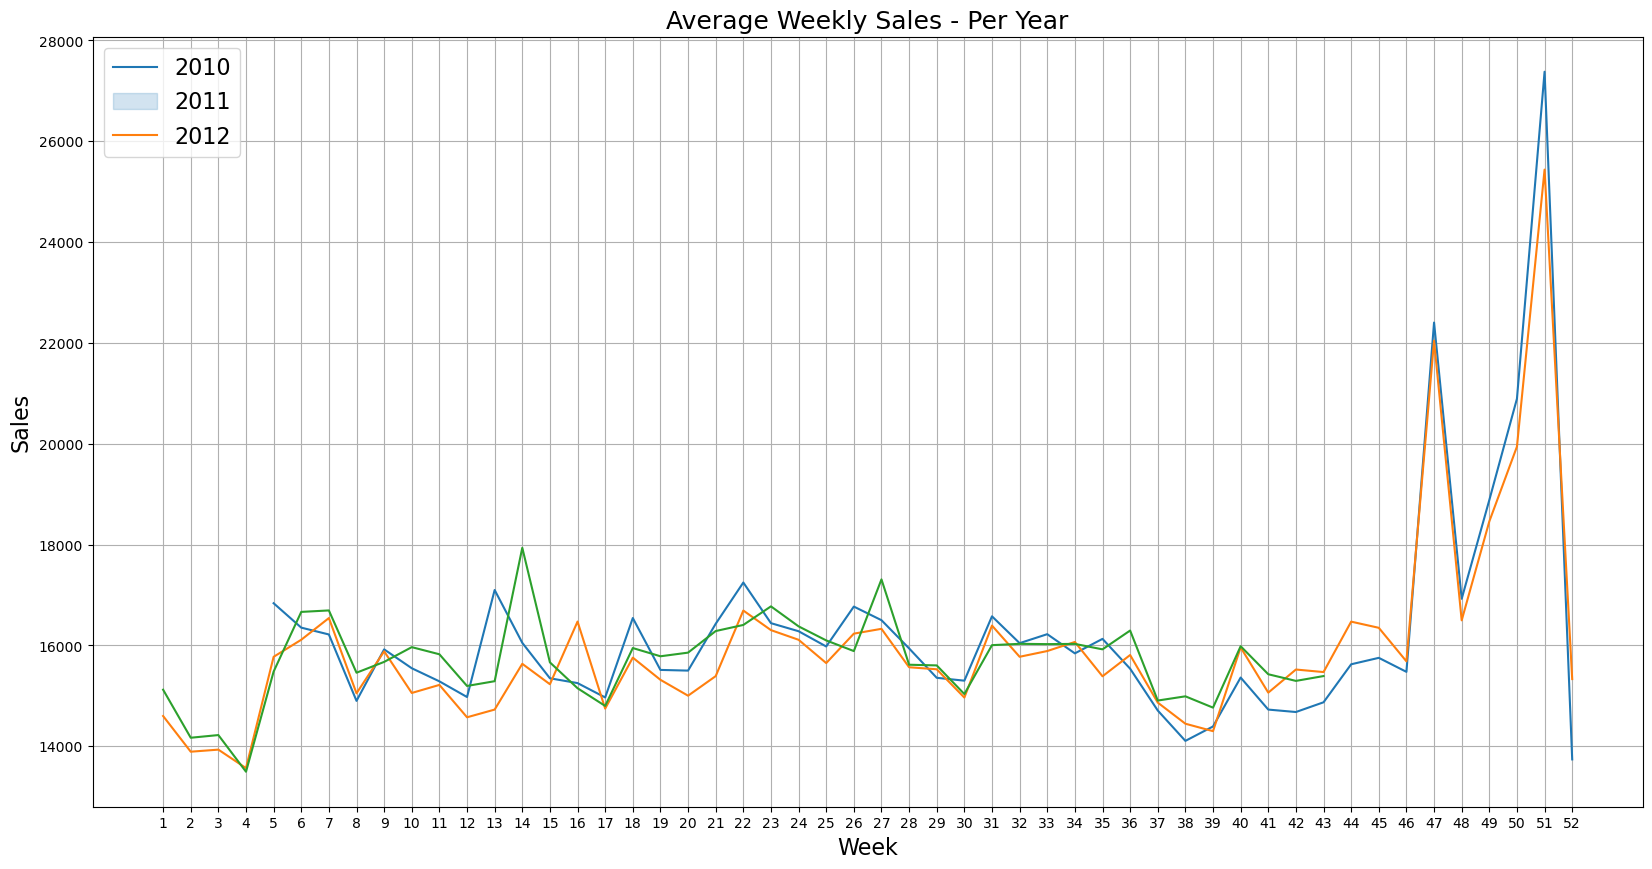

In [16]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,10))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

## Observation 2
As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

In 2010 is in Week 13
In 2011, Week 16
Week 14 in 2012
and, finally, Week 13 in 2013 for Test set
So, we can change to 'True' these Weeks in each Year.

### **Adding Easter**

In [17]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

# Weekly Sales - Mean and Median

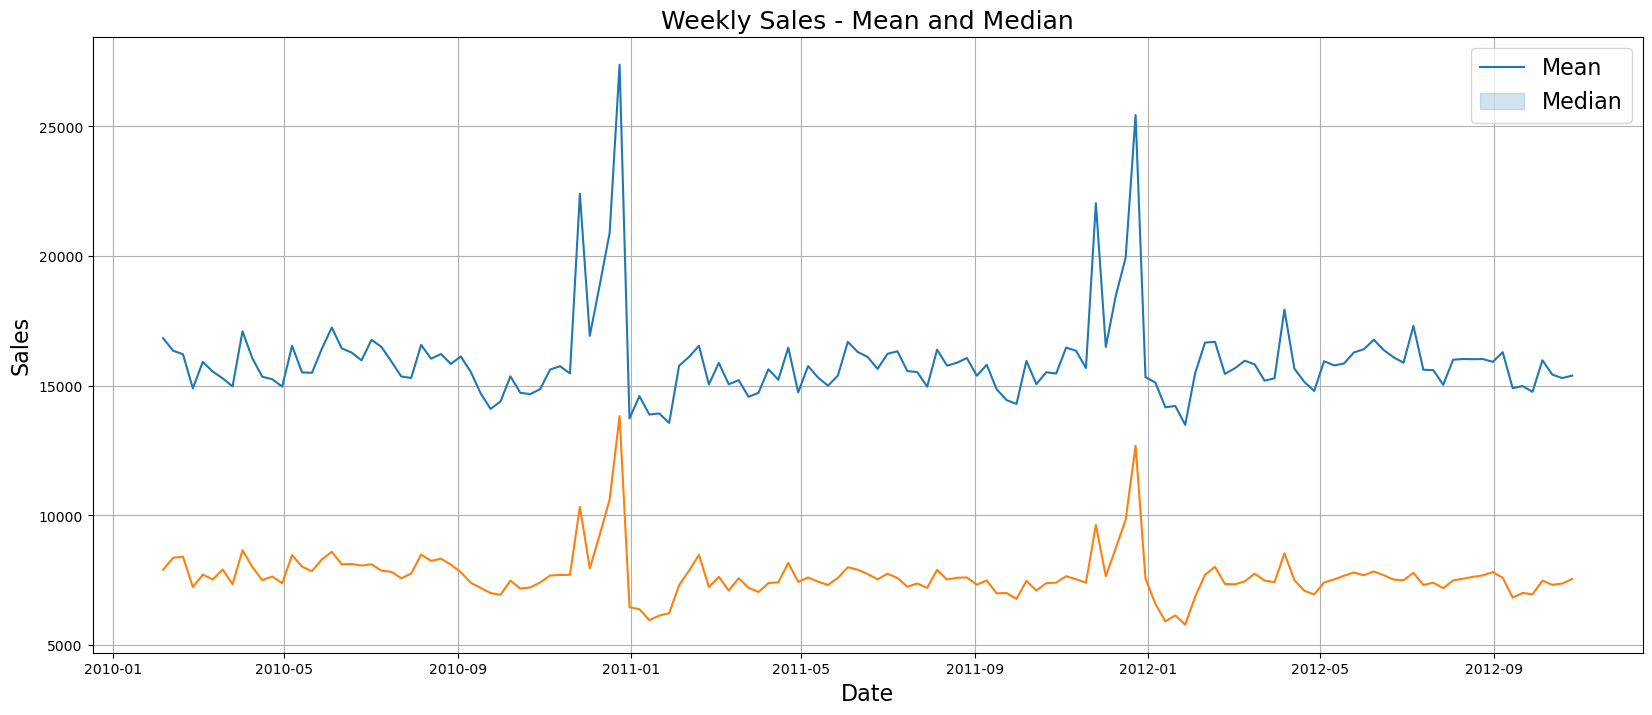

In [18]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values)
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values)

plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

# Average Sales per Store and Department

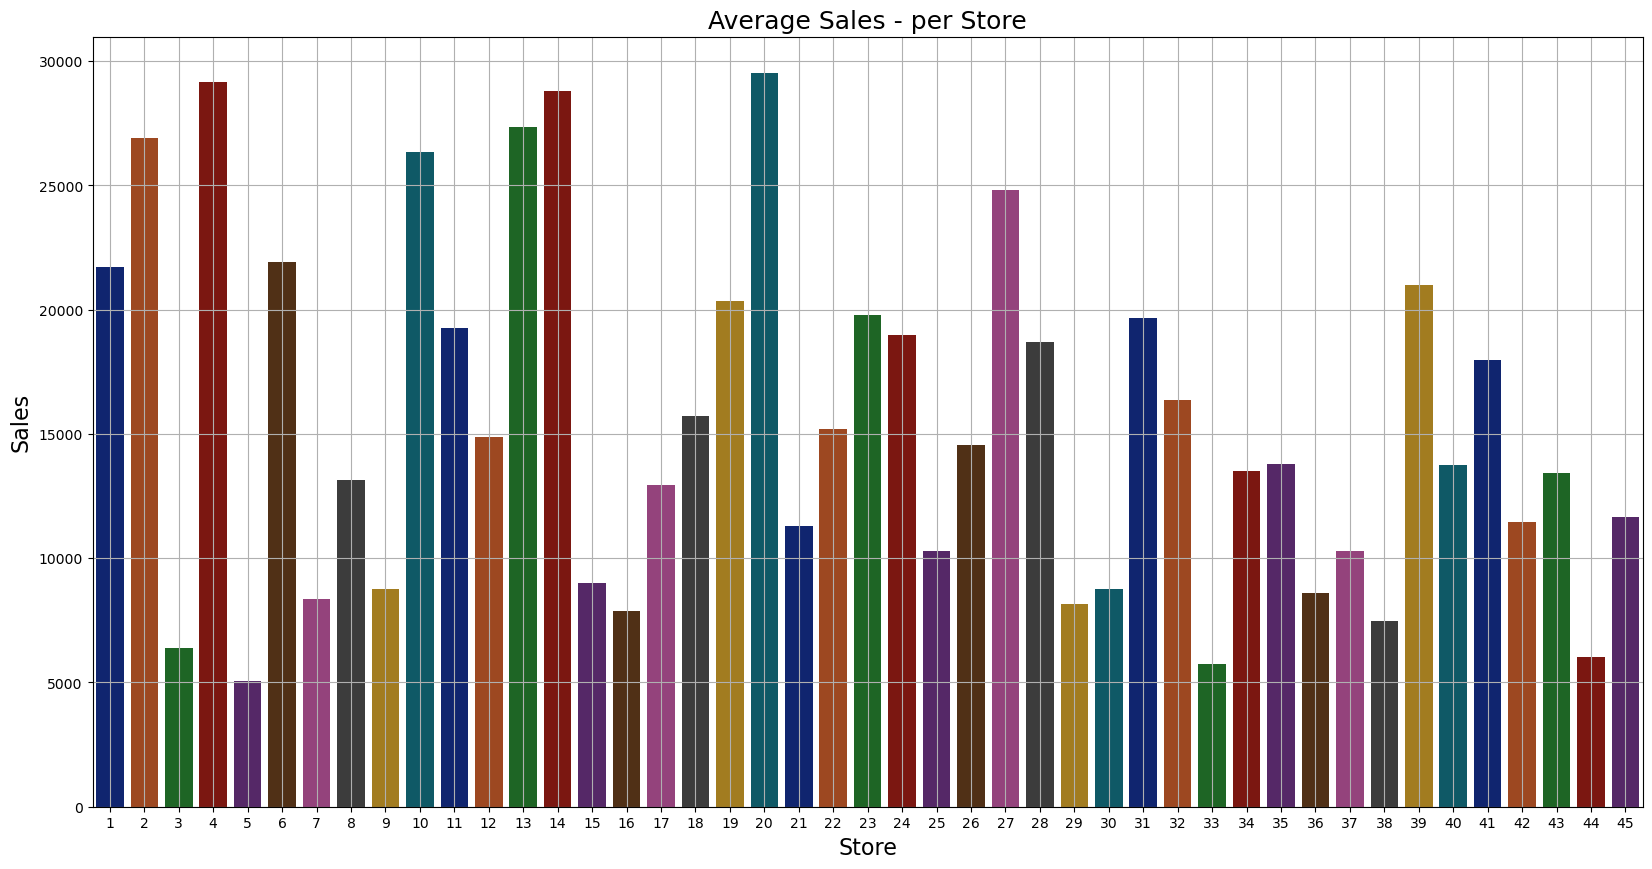

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,10))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


# Average Sales - Department Wise

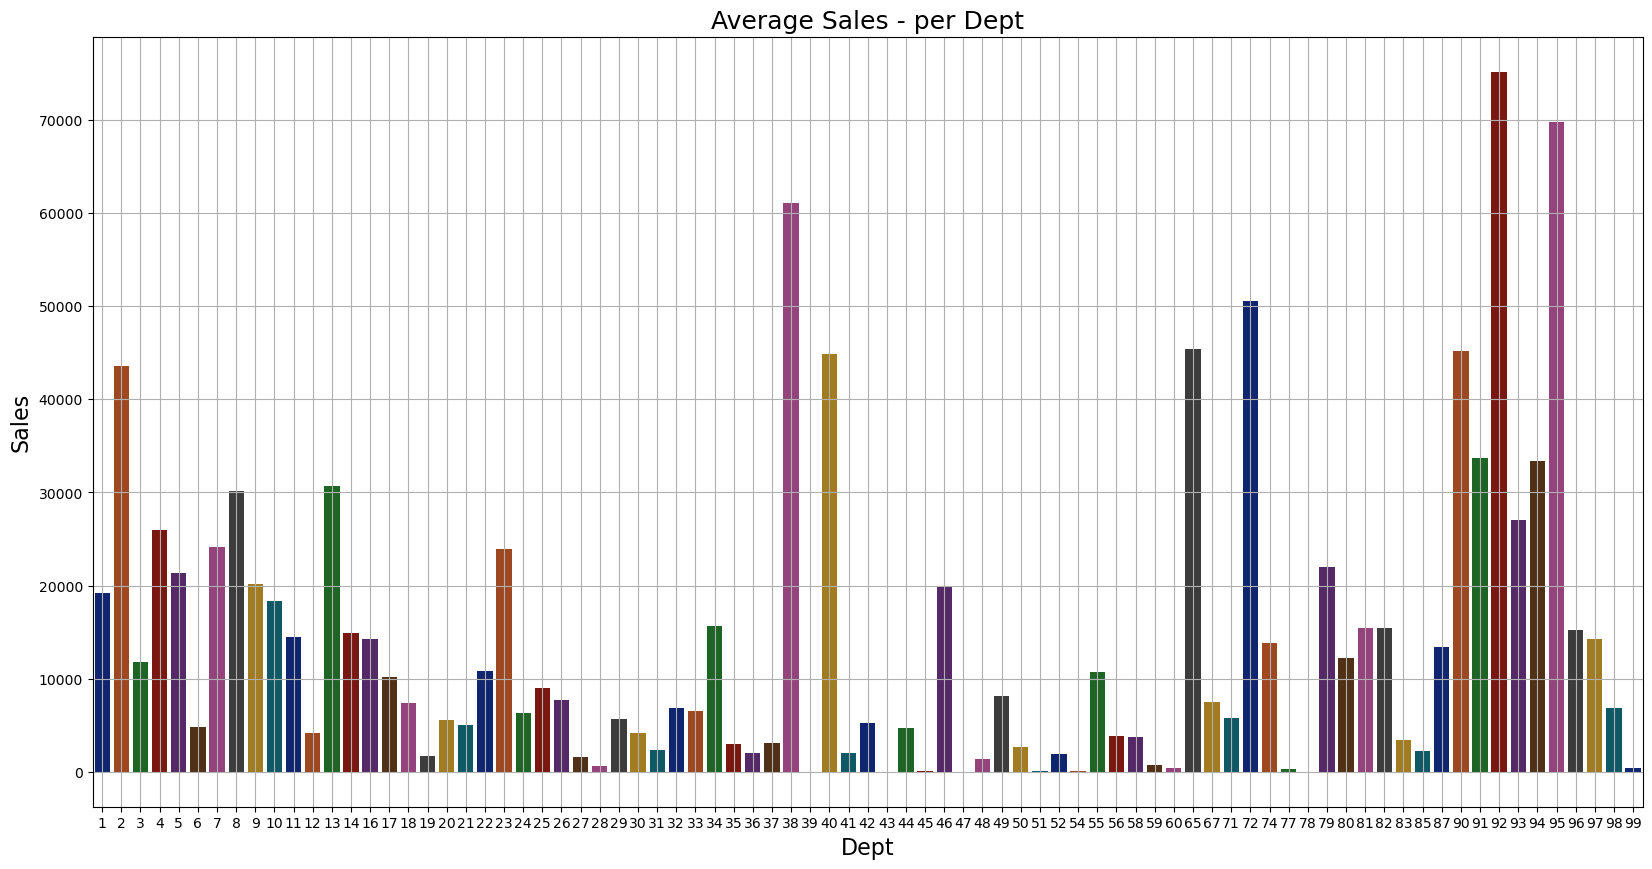

In [20]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(20,10))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

## Obeservation 3
There are Sales difference between the Store and Departments. Also some Depts are not in the list, like number '15', for example.

# Correlation Matrix - Pearson Correlation

Correlation Metrics:

* 0: no correlation at all
* 0-0.3: weak correlation
* 0.3-0.7: moderate correlaton
* 0.7-1: strong correlation

**Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.**

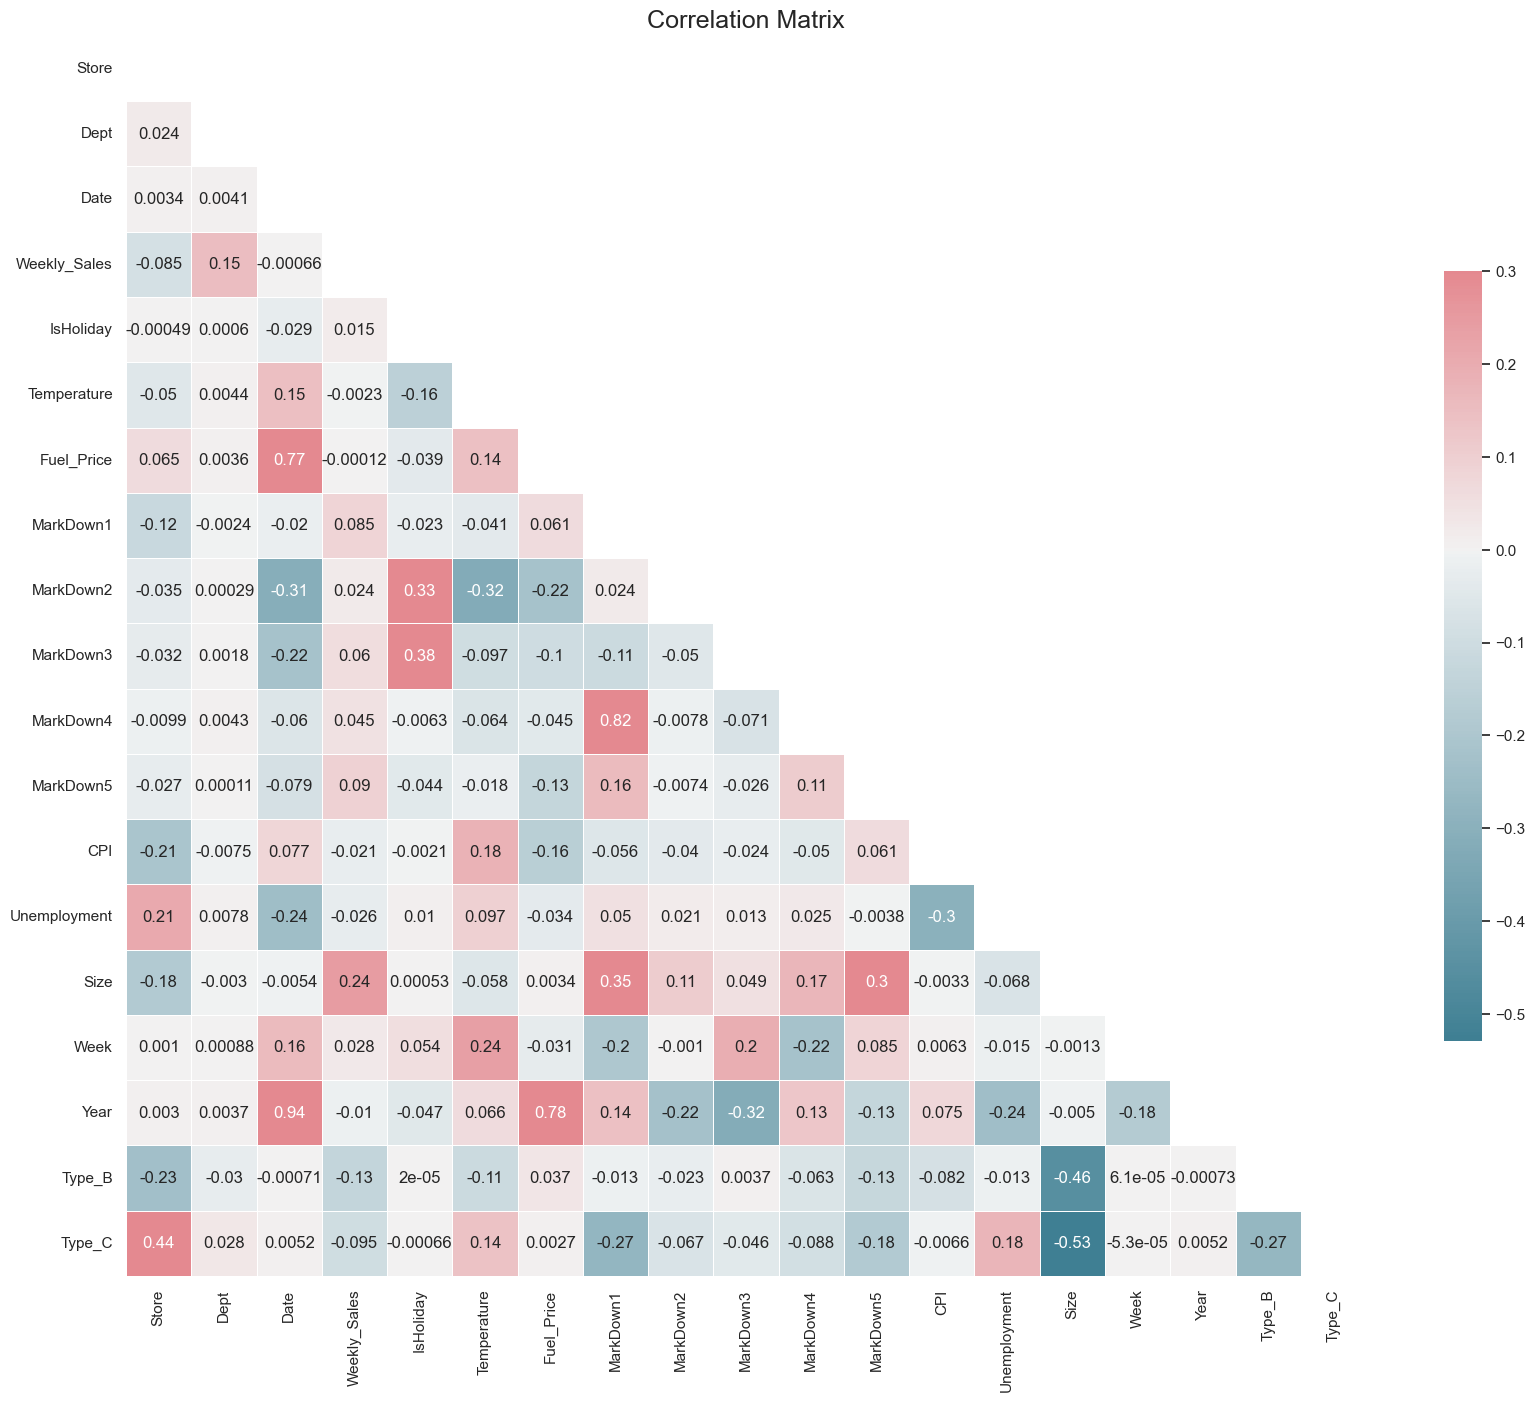

In [21]:
sns.set(style="white")

# Convert categorical data to numerical data
train_detail_encoded = pd.get_dummies(train_detail, columns=['Type'], drop_first=True)

corr = train_detail_encoded.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Observation 4
'**MarkDown**' 1 to 5 are not strong correlated to '**Weekly_Sales**' and they have a lot of null values, then we can drop them.

Also, '**Fuel_Price**' is strong correlated to '**Year**'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

Other variables that have weak correlation with '**Weekly_Sales**' can be analyzed to see if they are useful.

**Droping Markdown values**

In [22]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])